# ERiC

### Implementation

The correlation clustering algorithm ERiC is implemented in the *lib.py* file, which contains several key methods:


* *make_partitions(D, k, α)*   
This method takes the full data set D and the hyperparameter k and α and assigns a dimensionality $\lambda$ to every point, which represents the partition in which it is in. The parameter k determines the size of the nearest neighbourhood of point p, which is used for computing the eigenvalue decomposition. The parameter α determines the portion of explained variance, and it is usually between 0.8 and 0.9, in our case it is 0.85 by default.Some partitions might remain empty. Partition $P_d$ contains noise, since there is no linear dependency of features within the neighborhood of point p.



* *cluster_partitions(D, partitions, $\Delta$, δ, min_samples)*  
Performs DBSCAN to compute clusters within each partition. The hyperparameters used are $\Delta$, used for determining the approximate linear dependency, while parameter δ for the affine distance. The input parameter ε determining the range of neighborhood is set to a value very close to 0 since the distance d is binary. The parameter min_samples determines the minimum size of a cluster. 


* *build_hierarchy(cluster_list, $\Delta$, δ)*  
As input contains a list of clusters, sorted by its $\lambda$ value. The method assignes the parents for each cluster. If the correlation distance between two clusters is 0, then cluster $C_n$ is treated as parent of cluster $C_m$, unless $C_n$ is a parent of any cluster $C_o$ that in turn is already a parent of $C_m$, because in that case the relationship between $C_n$ and $C_m$ is that of a grandparent.


The validation of the implementation of the algorithm is carried out in the notebook [ERiC_Validation.ipynb](http://localhost:8888/notebooks/ERiC_Validation.ipynb)

### Hyperparameters

The hyperparameter tunning is carried out in the file: *hyperparameter_tuning.py.py* which helped us pick the hyperparameters to run the different kernels with.

We have tried several combinations of the following hyperparameters: k, Δ and δ. For analyzing the results, since it is not straight forward to compute the NMI since we have groups of cluster for every dimensions, which are connected between dimensions, we plotted them by ordering them in the same horizontal line - correspoding to the descending 𝜆 value, and coloring the nodes by with a color between blue and red, indicating the amount of presence of the two labels (purple color means there are somewhat equal amounts of both values present in the cluster). 

The minPts parameter for DBSCAN is set to 2 by default, since there are already a lot of points showing up in the noise cluster, and in the EDA.ipynb notebook it has been shown that a greater value of this parameters accumulates more noisy points.


The plots from the hyperparameter tuning can be foind in plot_trees.ipynb.

##### Note:  Limitations

* Parameter k  
The paper of the algorithm states that k needs to be much larger then the dimensionality of the data. However, our dataset has the same number of samples as features (both being 1000). Due to this reason we had to chose k either equal to d (which will not produce meaningful results) or smaller. We chose several values of k (100, 250 and 500). In any case, the results did not seem meaningful as the hierarchy seems to connect nearly every cluster to the noise cluster.


* Runtime memory  
The algorithm takes up a lot of memory, since we focues on making it run faster, hence we save up eigenvalue patrices and some other precoputed values so it can run smoothly. This, however, produces outputs that take up quite a few GB and makes the proces of finding good parameters to produce meaninful results much harder.  

### Kernels

We run the algorithm with the best hyperparameters for every kernel. We have used only the WL kernels in this case, because the graphlet and shortest path kernel did not work well for this setting, which was also shown in the *EDA.ipynb notebook*. This is carried out in the file *kernel_computation.ipynb*. 

Kernel:  wl1


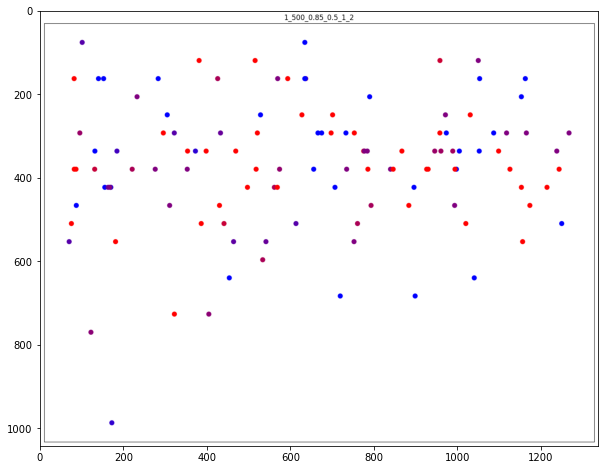

Kernel:  wl2


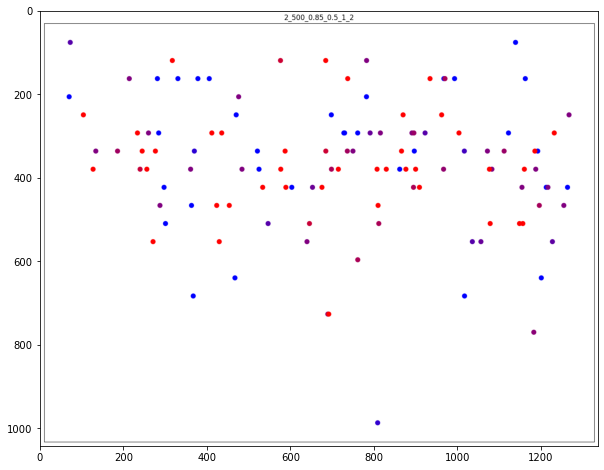

Kernel:  wl3


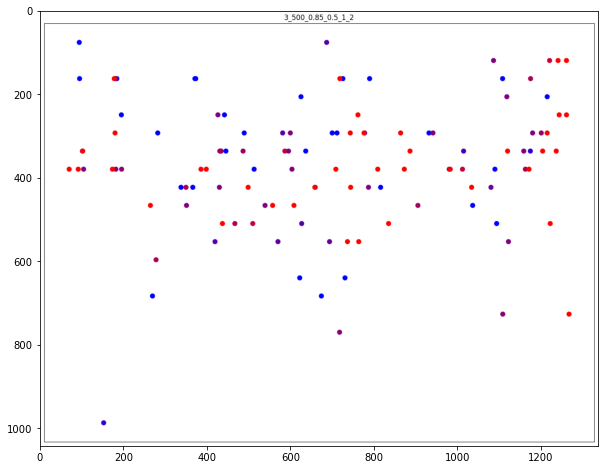

Kernel:  wl4


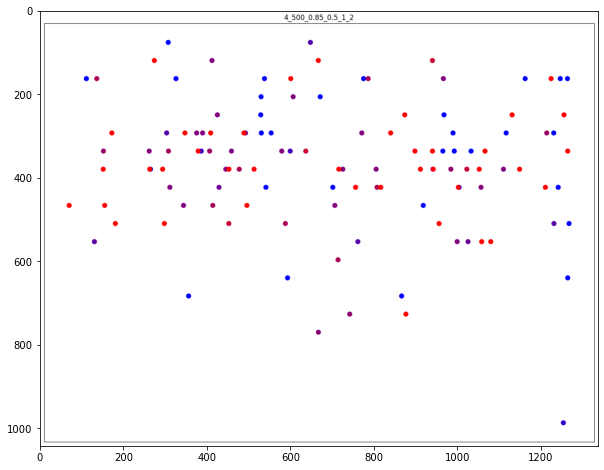

Kernel:  wl5


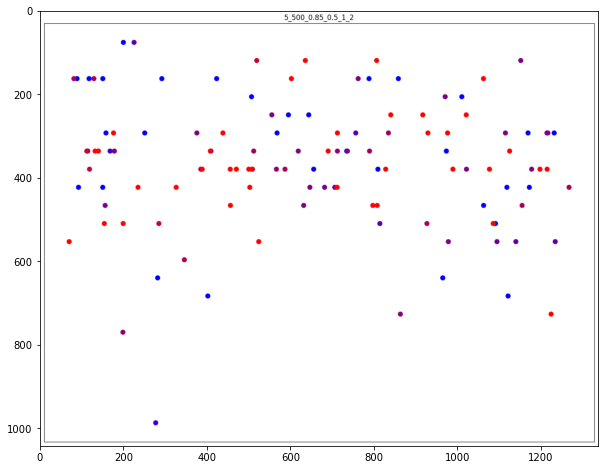

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i, kernel in enumerate(["wl1", "wl2", "wl3", "wl4", "wl5"]):
    # get the image
    print("Kernel: ", kernel)
    img = mpimg.imread(f"{i+1}_500_0.85_0.5_1_2.png")
    plt.figure(figsize = (10,10))
    imgplot = plt.imshow(img)
    plt.show()

In [57]:
#TO DO comment:

Now we take a look at the sizes of each cluster per kernel:

wl1


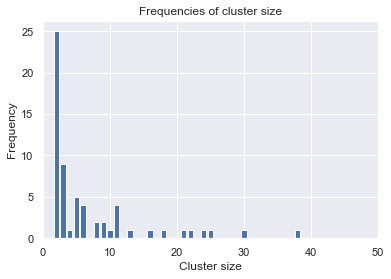

wl2


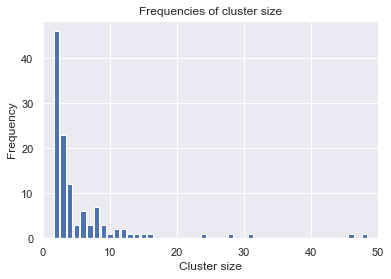

wl3


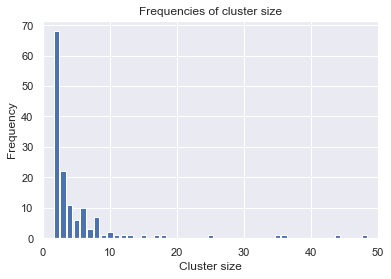

wl4


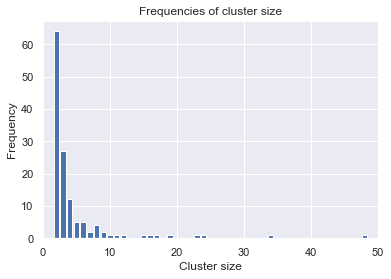

wl5


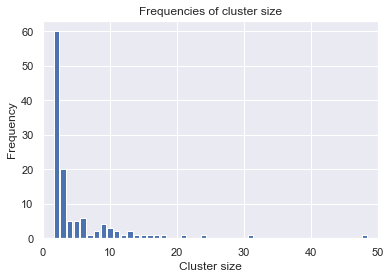

In [82]:
import os
import numpy as np
from lib import *
import pickle
from matplotlib import pyplot as plt
import collections
import seaborn as sns
sns.set_theme()

pickle_path = 'pickles'
kernels = ["wl1", "wl2", "wl3", "wl4", "wl5"]

for i, kernel in enumerate(kernels):
    cluster_info = pickle.load(open(os.path.join(pickle_path, f'cluster_info_{i+1}_500_0.85_0.5_1_2.p'), 'rb'))
    cluster_sizes = [len(cluster_info[c]["points"]) for c in cluster_info.keys()]
      
    print(kernel)

    # frequency of cluster sizes
    c = collections.Counter(cluster_sizes)
    c = sorted(c.items())
    sizes = [j[0] for j in c]
    freqs = [j[1] for j in c]
    
    plt.bar(sizes, freqs)
    plt.title("Frequencies of cluster size")
    plt.xlabel("Cluster size")
    plt.ylabel("Frequency")
    plt.xlim([0, 50])
    plt.show()


In [58]:
## TO DO: comment 

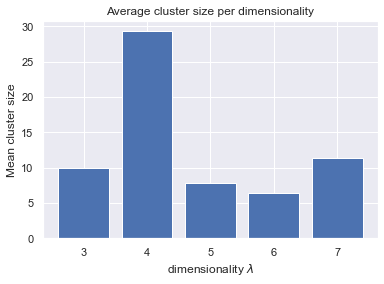

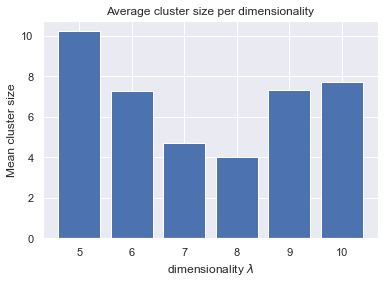

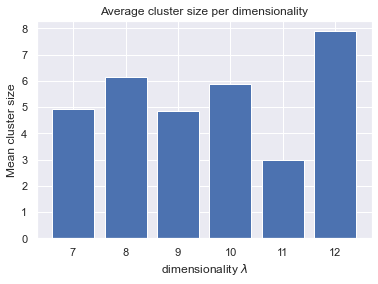

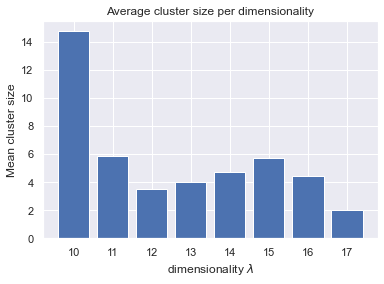

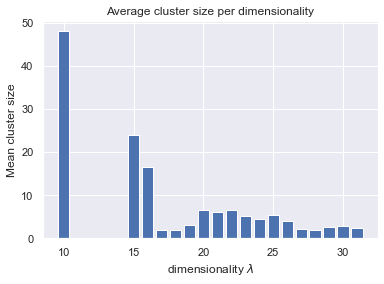

In [84]:
cluster_noise_sizes = []

for i, kernel in enumerate(kernels):
    # average size per dimension
    cluster_info = pickle.load(open(os.path.join(pickle_path, f'cluster_info_{i+1}_500_0.85_0.5_1_2.p'), 'rb'))
    lambdas = [cluster_info[c]["lambda"] for c in cluster_info.keys()]
    c_keys = [c for c in cluster_info.keys()]
    lambdas_dict = {}

    for l in lambdas[0:-1]:
        cluster_size = [len(cluster_info[c]["points"]) for c in cluster_info.keys() if cluster_info[c]["lambda"] == l]
        lambdas_dict[l] = sum(cluster_size)/len(cluster_size)
    
    # plot noise cluster separately
    cluster_noise_sizes.append(len(cluster_info[c_keys[-1]]["points"]))   
    
    plt.bar(lambdas_dict.keys(), lambdas_dict.values())
    plt.title("Average cluster size per dimensionality")
    plt.xlabel("dimensionality $\lambda$")
    plt.ylabel("Mean cluster size")
    plt.show()   

In [ ]:
# TO DO: comment

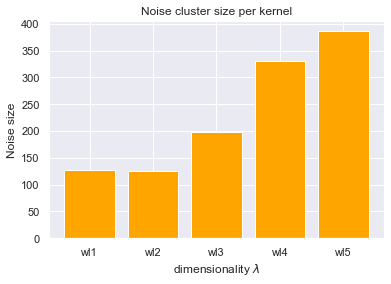

In [88]:
# plot noise sizes
plt.bar(kernels, cluster_noise_sizes, color="orange")
plt.title("Noise cluster size per kernel")
plt.xlabel("dimensionality $\lambda$")
plt.ylabel("Noise size")
plt.show()

In [ ]:
# TO DO: comment

wl1


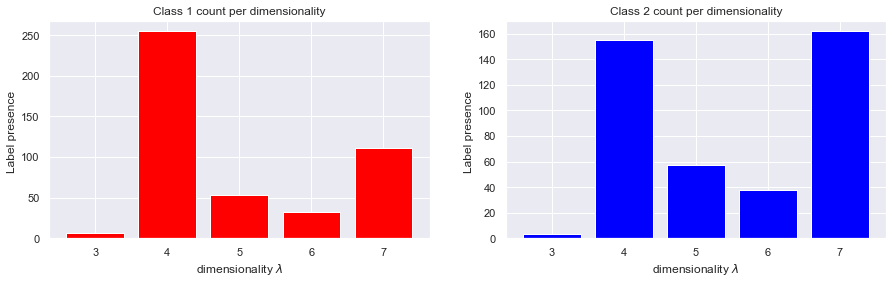

wl2


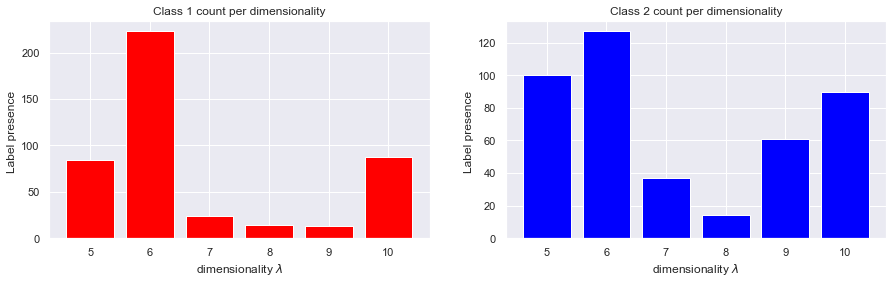

wl3


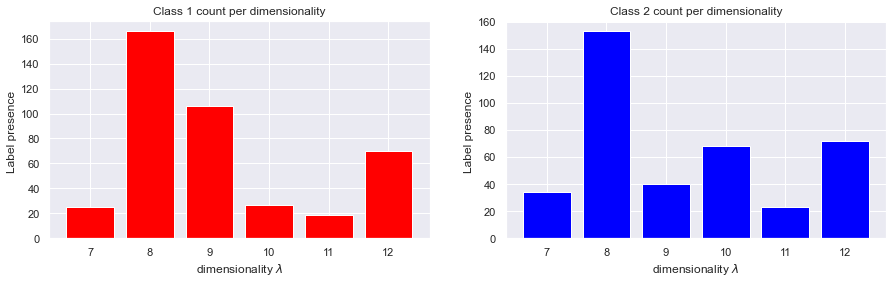

wl4


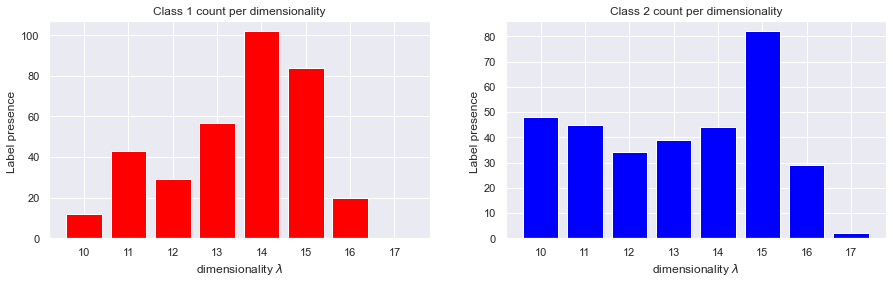

wl5


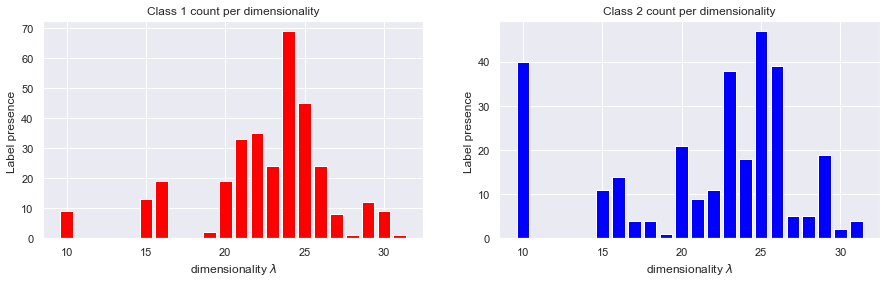

In [132]:
for i, kernel in enumerate(kernels):
    # average size per dimension
    cluster_info = pickle.load(open(os.path.join(pickle_path, f'cluster_info_{i+1}_500_0.85_0.5_1_2.p'), 'rb'))
    lambdas = [cluster_info[c]["lambda"] for c in cluster_info.keys()]
    
    print(kernel)
    
    class_1_list = []
    class_2_list = []
    for l in lambdas[0:-1]:
        class_1 = [np.count_nonzero(np.array(cluster_info[c]['points']) > 499) for c in cluster_info.keys() if cluster_info[c]["lambda"] == l]
        class_2 = [np.count_nonzero(np.array(cluster_info[c]['points']) <= 500) for c in cluster_info.keys() if cluster_info[c]["lambda"] == l]
        
        class_1_list.append(sum(class_1))
        class_2_list.append(sum(class_2))
            

    fig, axs = plt.subplots(1,2)
    fig.set_figwidth(15)
    axs[0].bar(lambdas[0:-1], class_1_list, color="red")
    axs[0].set_title("Class 1 count per dimensionality")
    axs[0].set_xlabel("dimensionality $\lambda$")
    axs[0].set_ylabel("Label presence ")
    
    axs[1].bar(lambdas[0:-1], class_2_list, color="blue")
    axs[1].set_title("Class 2 count per dimensionality")
    axs[1].set_xlabel("dimensionality $\lambda$")
    axs[1].set_ylabel("Label presence ")
    
    plt.show() 

In [ ]:
# add boxplots 
# TO DO: NMI for 2 biggest clusters (not noise)